In [212]:
# opening configuration file, saving into a variable, then establishing that variable as env which specifies the data as development
# environment credentials


with open('sql/config.json') as datafile:
    data = json.load(datafile)

env = data['dev']


In [213]:
import pandas as pd
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
from flask import Flask, jsonify
from sqlalchemy.engine import url
import json
from sqlalchemy import extract
from sqlalchemy.engine import make_url
import psycopg2
from sqlalchemy.sql import text

In [214]:
# Instantiating the environment column values as the column names to hide sensitive data

db = env['db']
user = env['user']
password = env['pass']
port = env['port']
host = env['host']

In [215]:
# Connection string

engine = sqlalchemy.create_engine(f'postgresql://{user}:{password}@{host}:{port}/{db}')


In [216]:
# Reflecting an existing DB into a new model
Base = automap_base()

In [217]:

#Trying another method reflecting tables

Base.prepare(autoload_with = engine)

In [218]:
# Seeing what tables there are

Base.classes.keys()

['jhu_cre_cases_deaths', 'location']

In [219]:
# Saving the tables as references here if u want 

location = Base.classes.location

In [220]:
# Another table reference 

jhu_data = Base.classes.jhu_cre_cases_deaths

In [221]:
# Create our session from python to DB
#Create a session object to intiiate query in db

from sqlalchemy.orm import sessionmaker

Session = sessionmaker(bind = engine)
session = Session()

In [222]:
# Test query to make sure database connection works

query = session.query(jhu_data)

In [223]:
#SQL only accepts str vals so have to convert query into string so that its readable by sql, but then we have a df we can
# manipulate however. This should not fail and allow you to do whatever with the data. (No more worries abt csvs etc yay!)

jhucredf = pd.DataFrame(engine.connect().execute(str(query)))

In [224]:
jhucredf

,0,1,2,3,4,5,6,7,8,9,...,31,32,33,34,35,36,37,38,39,40
0,1001,19732,230,32.539527,-86.644082,Alabama,Autauga County,55688,55380,20573,...,723,111,49283,779,29291,3953,44884,2450,779,1726
1,1003,69641,724,30.727750,-87.722071,Alabama,Baldwin County,221898,212830,78622,...,2218,887,201483,3994,112058,19748,181512,7322,7322,96747
2,1005,7451,103,31.868263,-85.387129,Alabama,Barbour County,22023,25361,5024,...,220,132,16120,572,8170,2488,13323,2246,836,1629
3,1007,8067,109,32.996421,-87.125115,Alabama,Bibb County,20393,22493,6280,...,346,163,16130,265,8096,2182,14111,1264,305,1142
4,1009,18616,261,33.982109,-86.567906,Alabama,Blount County,57697,57681,18189,...,1038,115,46446,1961,27463,6231,42118,2365,403,4846
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3137,56037,12484,139,41.659439,-108.882788,Wyoming,Sweetwater County,41888,43521,16977,...,502,209,38872,1298,21739,4733,35185,712,879,12817
3138,56039,12123,16,43.935225,-110.589080,Wyoming,Teton County,23390,23280,7250,...,140,771,22267,1777,13028,2970,20372,561,467,5730
3139,56041,6378,43,41.287818,-110.547578,Wyoming,Uinta County,20183,20479,7744,...,322,141,18709,322,10091,2260,18063,686,100,2401
3140,56043,2749,50,43.904516,-107.680187,Wyoming,Washakie County,7738,8027,2601,...,108,77,6948,108,3869,1160,6051,379,15,1903


In [225]:
sql = '''
    SELECT * FROM jhu_cre_cases_deaths;
'''
with engine.connect() as conn:
    query = conn.execute(text(sql))
df = pd.DataFrame(query.fetchall())

In [226]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,31,32,33,34,35,36,37,38,39,40
0,1001,19732,230,32.539527,-86.644082,Alabama,Autauga County,55688,55380,20573,...,723,111,49283,779,29291,3953,44884,2450,779,1726
1,1003,69641,724,30.727750,-87.722071,Alabama,Baldwin County,221898,212830,78622,...,2218,887,201483,3994,112058,19748,181512,7322,7322,96747
2,1005,7451,103,31.868263,-85.387129,Alabama,Barbour County,22023,25361,5024,...,220,132,16120,572,8170,2488,13323,2246,836,1629
3,1007,8067,109,32.996421,-87.125115,Alabama,Bibb County,20393,22493,6280,...,346,163,16130,265,8096,2182,14111,1264,305,1142
4,1009,18616,261,33.982109,-86.567906,Alabama,Blount County,57697,57681,18189,...,1038,115,46446,1961,27463,6231,42118,2365,403,4846


In [227]:
import os
data = os.path.join("JHU_Cases_Deaths_with_CRE_Data_2_0.csv")

df = pd.read_csv(data)

df.columns

Index(['fips', 'cases', 'deaths', 'lat', 'long', 'state', 'county', 'popuni',
       'total_population', 'zero_rf', 'one_two_rf', 'three_rf',
       'housing_units', 'hispanic_pop', 'white_pop', 'black_pop', 'native_pop',
       'asian_pop', 'pacific_islander_pop', 'other_race_pop',
       'bi_tri_racial_pop', 'male_pop', 'female_pop', 'veteran',
       'gini_ind_income', 'rural_pop', 'median_age_pop', 'elder_pop',
       'disability_pop', 'below_poverty_level', 'single_mothers_pop',
       'single_fathers_pop', 'plus_family_homes', 'highschool_grad',
       'multilingual_5yrs_plus', 'full_time_workers', 'no_health_insur',
       'internet_homes', 'no_vehicle', 'homeowner_vacancy', 'rental_vacancy'],
      dtype='object')

In [228]:
df.drop(columns=(["lat","long","state","county","fips"]), inplace= True)

In [229]:
df.dtypes

cases                     int64
deaths                    int64
popuni                    int64
total_population          int64
zero_rf                   int64
one_two_rf                int64
three_rf                  int64
housing_units             int64
hispanic_pop              int64
white_pop                 int64
black_pop                 int64
native_pop                int64
asian_pop                 int64
pacific_islander_pop      int64
other_race_pop            int64
bi_tri_racial_pop         int64
male_pop                  int64
female_pop                int64
veteran                   int64
gini_ind_income           int64
rural_pop                 int64
median_age_pop            int64
elder_pop                 int64
disability_pop            int64
below_poverty_level       int64
single_mothers_pop        int64
single_fathers_pop        int64
plus_family_homes         int64
highschool_grad           int64
multilingual_5yrs_plus    int64
full_time_workers         int64
no_healt

In [230]:
df

,cases,deaths,popuni,total_population,zero_rf,one_two_rf,three_rf,housing_units,hispanic_pop,white_pop,...,single_fathers_pop,plus_family_homes,highschool_grad,multilingual_5yrs_plus,full_time_workers,no_health_insur,internet_homes,no_vehicle,homeowner_vacancy,rental_vacancy
0,19732,230,55688,55380,20573,22750,12365,23493,1559,41543,...,723,111,49283,779,29291,3953,44884,2450,779,1726
1,69641,724,221898,212830,78622,90552,52724,114164,10207,184397,...,2218,887,201483,3994,112058,19748,181512,7322,7322,96747
2,7451,103,22023,25361,5024,9171,7828,12013,969,10086,...,220,132,16120,572,8170,2488,13323,2246,836,1629
3,8067,109,20393,22493,6280,8986,5127,9185,530,15192,...,346,163,16130,265,8096,2182,14111,1264,305,1142
4,18616,261,57697,57681,18189,23950,15558,24323,5365,50138,...,1038,115,46446,1961,27463,6231,42118,2365,403,4846
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3137,12484,139,41888,43521,16977,17781,7130,19771,6660,33342,...,502,209,38872,1298,21739,4733,35185,712,879,12817
3138,12123,16,23390,23280,7250,11567,4573,13848,3508,19016,...,140,771,22267,1777,13028,2970,20372,561,467,5730
3139,6378,43,20183,20479,7744,9346,3093,9041,1836,17660,...,322,141,18709,322,10091,2260,18063,686,100,2401
3140,2749,50,7738,8027,2601,3215,1922,3860,1098,6337,...,108,77,6948,108,3869,1160,6051,379,15,1903


In [234]:
death_catlow = 47
death_catmed = 110
death_cathigh = 261

for index, row in df.iterrows():
    deaths = row['deaths']
    if deaths <= death_catlow:
        df.loc[index, 'death_cat'] = 'low'
    elif death_catlow < deaths <= death_catmed:
        df.loc[index, 'death_cat'] = 'med'
    else:
        df.loc[index, 'death_cat'] = 'high'

df.columns

In [235]:
import pandas as pd
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
#PCA (Principal Component Analysis)
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Linear Regression Model against Risk Factors

In [340]:
from sklearn.preprocessing import LabelEncoder
df['death_cat'] = LabelEncoder().fit_transform(df['death_cat'])

In [341]:
df.head(10)

,cases,deaths,popuni,total_population,zero_rf,one_two_rf,three_rf,housing_units,hispanic_pop,white_pop,...,plus_family_homes,highschool_grad,multilingual_5yrs_plus,full_time_workers,no_health_insur,internet_homes,no_vehicle,homeowner_vacancy,rental_vacancy,death_cat
0,19732,230,55688,55380,20573,22750,12365,23493,1559,41543,...,111,49283,779,29291,3953,44884,2450,779,1726,0
1,69641,724,221898,212830,78622,90552,52724,114164,10207,184397,...,887,201483,3994,112058,19748,181512,7322,7322,96747,0
2,7451,103,22023,25361,5024,9171,7828,12013,969,10086,...,132,16120,572,8170,2488,13323,2246,836,1629,2
3,8067,109,20393,22493,6280,8986,5127,9185,530,15192,...,163,16130,265,8096,2182,14111,1264,305,1142,2
4,18616,261,57697,57681,18189,23950,15558,24323,5365,50138,...,115,46446,1961,27463,6231,42118,2365,403,4846,0
5,3020,54,8600,10248,2074,3534,2992,4557,223,1840,...,0,6424,86,4274,980,5168,920,17,60,2
6,6518,132,19410,19828,5431,7643,6336,10089,271,10015,...,116,16498,77,9200,1688,12538,1455,718,4503,0
7,41228,675,111694,114618,35169,44189,32336,53631,4244,80531,...,446,94269,1675,51267,10610,83882,6701,2345,6254,0
8,10812,170,33117,33660,9457,12798,10862,16988,794,18379,...,1192,27023,430,16889,3411,22983,2417,894,3079,0
9,6732,89,26116,25903,7374,11044,7698,16579,417,23948,...,130,21310,182,12718,2245,18464,1175,861,3577,2


In [342]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
X = df[['zero_rf', 'one_two_rf', 'three_rf'
      ]]
y= df['death_cat']

In [343]:
from sklearn import linear_model

In [344]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [345]:
# from sklearn.linear_model import LogisticRegression
# classifier = LogisticRegression()
# classifier

In [346]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()

In [347]:
model.fit(X_train, y_train)

LinearRegression()

In [348]:
# Fit the model to the training data, and calculate the scores for the training and testing data.

### BEGIN SOLUTION
model.fit(X_train, y_train)
training_score = model.score(X_train, y_train)
testing_score = model.score(X_test, y_test)

### END SOLUTION 

print(f"Training Score: {training_score}")
print(f"Testing Score: {testing_score}")

Training Score: 0.09992806665096843
Testing Score: 0.06749083429475833


In [349]:
# Calculate the mean_squared_error and the r-squared value
# for the testing data

from sklearn.metrics import mean_squared_error, r2_score

### BEGIN SOLUTION

# Use our model to make predictions
predicted = model.predict(X_test)

# Score the predictions with mse and r2
mse = mean_squared_error(y_test, predicted)
r2 = r2_score(y_test, predicted)

print(f"mean squared error (MSE): {mse}")
print(f"R-squared (R2): {r2}")


mean squared error (MSE): 0.6496829497310048
R-squared (R2): 0.06749083429475833


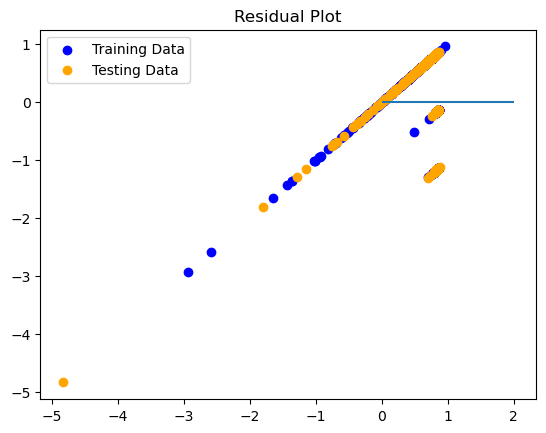

In [350]:
plt.scatter(model.predict(X_train), model.predict(X_train) - y_train, c="blue", label="Training Data")
plt.scatter(model.predict(X_test), model.predict(X_test) - y_test, c="orange", label="Testing Data")
plt.legend()
plt.hlines(y=0, xmin=y.min(), xmax=y.max())
plt.title("Residual Plot")
plt.show()

In [338]:
model.score(X_test, y_test)

0.06749083429475833

In [339]:
death_catlow = 47
death_catmed = 110
death_cathigh = 261

for index, row in df.iterrows():
    deaths = row['deaths']
    if deaths <= death_catlow:
        df.loc[index, 'death_cat'] = 'low'
    elif death_catlow < deaths <= death_catmed:
        df.loc[index, 'death_cat'] = 'med'
    else:
        df.loc[index, 'death_cat'] = 'high'

In [72]:
df.head()

,fips,cases,deaths,lat,long,state,county,popuni,total_population,zero_rf,...,plus_family_homes,highschool_grad,multilingual_5yrs_plus,full_time_workers,no_health_insur,internet_homes,no_vehicle,homeowner_vacancy,rental_vacancy,death_cat
0,1001,19732,230,32.539527,-86.644082,Alabama,Autauga County,55688,55380,20573,...,111,49283,779,29291,3953,44884,2450,779,1726,high
1,1003,69641,724,30.727750,-87.722071,Alabama,Baldwin County,221898,212830,78622,...,887,201483,3994,112058,19748,181512,7322,7322,96747,high
2,1005,7451,103,31.868263,-85.387129,Alabama,Barbour County,22023,25361,5024,...,132,16120,572,8170,2488,13323,2246,836,1629,med
3,1007,8067,109,32.996421,-87.125115,Alabama,Bibb County,20393,22493,6280,...,163,16130,265,8096,2182,14111,1264,305,1142,med
4,1009,18616,261,33.982109,-86.567906,Alabama,Blount County,57697,57681,18189,...,115,46446,1961,27463,6231,42118,2365,403,4846,high


In [79]:
from sklearn.preprocessing import LabelEncoder
df['death_cat'] = LabelEncoder().fit_transform(df['death_cat'])